Selection a position to query around

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astroquery.mast import Catalogs
from astroquery.mast import Observations
import bokeh
from bokeh.models.tools import *
from bokeh.plotting import *
from bokeh.models import CustomJS, TapTool, ColumnDataSource, Row
from bokeh.models.widgets import Button
from random import choice
from string import ascii_lowercase
from bokeh.io import push_notebook, show, output_notebook, curdoc

from astropy.io import fits
from astropy.table import Table

from astroquery.mast import Observations
from astroquery.mast import Tesscut

%matplotlib inline

In [3]:
Observations.enable_cloud_dataset()

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


In [4]:
# select a region of the sky to query
ra = 180.
dec = +30.

In [5]:
# convert the coordinates and then query the TIC
coord = SkyCoord(ra, dec, unit="deg")
catalog_data = Catalogs.query_region(coord, radius=1, catalog="Tic")

In [6]:
# remove stars with poor parallaxes which would translate to poor distances etc
catalog_data = catalog_data[(catalog_data['d'] > 0) & (catalog_data['e_d'] / catalog_data['d'] < 0.1)]

# calculate the color and absolute magnitude of the star to generage an HR diagram
catalog_data['abs_gaia'] = catalog_data['GAIAmag'] - 5 * np.log10(catalog_data['d'] / 10)
catalog_data['color'] = catalog_data['gaiabp'] - catalog_data['gaiarp']

In [34]:
# I would like to make this re-cursive...
# step 1. select a point
# step 2. pull down the light curve and plot the light curve
# step 3. select another point and this automatically pulls down the light curve and plots
# plot the HR diagram
output_n-

source = ColumnDataSource(
    data=dict(
        x=list(catalog_data['color']),
        y=list(catalog_data['abs_gaia'])
    )
)

source2 = ColumnDataSource(data = dict(x = [], y = []))

callback = source.selected.js_on_change('indices', 
CustomJS(args=dict(source=source, source2=source2), code="""
    var inds = cb_obj.indices;
    var d1 = source.data;
    var d2 = source2.data;
    d2['x'] = []
    d2['y'] = []
    for (var i = 0; i < inds.length; i++) {
        d2['x'].push(d1['x'][inds[i]])
        d2['y'].push(d1['y'][inds[i]])
    }
    source2.data = d2
""")
)

def get_values():
    print(source2.data)  

taptool = TapTool(callback=callback)
p = figure(tools=[taptool], title="Select Here", x_axis_label="Gb-Gr",
           y_axis_label="Absolute G")
p.circle('x', 'y', source=source, alpha=0.6)
p.y_range.flipped = True
button = Button(label="Get selected set")
button.on_click(get_values)


show(p)

Loading BokehJS ...

In [27]:
# get the information from the TESS FFI
TESS_table = Observations.query_criteria(objectname="YY Oct"
                                         , obs_collection="TESS"
                                         , target_name="TESS FFI")


In [64]:
# search to get the first sector only
# Get the FFI cutout
hdulist = Tesscut.get_cutouts(objectname = "YY Oct"
                              , size=10    # return a 10x10 grid of pixels
                              , sector=13  # get only data from sector 13
                             )
# Load the first results
hdu1 = hdulist[0]

In [65]:
#This is a basic function for getting the aperture photometry and doing a background subtraction
def aperture_phot(image,aperture):
    flux = np.sum(image[aperture==1])
    return flux
def bkg_phot(image,aperture):
    flux = np.median(image[aperture==1]) * 100
    return flux

# Use all pixels in our aperture
aperture_ffi = hdu1[2].data

# get the data for the PIXELS extension of our fits file
pix_ffi = hdu1[1].data

# Use the map lambda function to sum all the flux in each pixel in our defined aperture
flux_ffi = np.array(list (map (lambda x: aperture_phot(x, aperture_ffi), pix_ffi['FLUX']))) 
bkg_ffi = np.array(list (map (lambda x: bkg_phot(x, aperture_ffi), pix_ffi['FLUX']))) 

# Get the time array so we have an x-axis to plot
time_ffi = hdu1[1].data['TIME']


(1000.0, 1500.0)

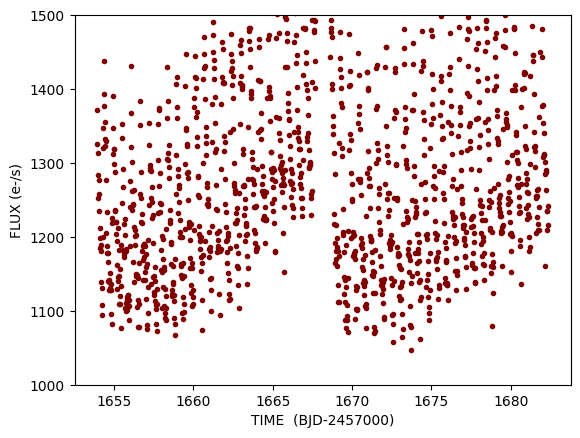

In [67]:
# Add the data and axis labels
plt.plot(time_ffi, flux_ffi - bkg_ffi,'.', color = "maroon")
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')
#plt.xlim([1655, 1660])
plt.ylim([1000, 1500])